Now that we have a few classes and funcs created, let's look at what could go wrong.

In [1]:
from arr import ContractHeader, annualize
from datetime import date

### Leap Years

Start with a 20k TCV contract starting on January 2024 and an ending on January 2026.

In [2]:
contract = ContractHeader(20_000, date(2024, 1, 15), date(2026, 1, 14))

period = date(2024, 6, 30)
interval_str = "Day"

dont_generalize_leap_year = annualize(contract, period, interval_str, False)
generalize_leap_year = annualize(contract, period, interval_str, True)

print("Results of leap year:")
print(f"Not generalizing leap year: {dont_generalize_leap_year:.2f}")
print(f"Generalizing leap year: {generalize_leap_year:.2f}")

Results of leap year:
Not generalizing leap year: 10013.68
Generalizing leap year: 10000.00


Simple thought would suggest that 20k TCV of 2 years will have a 10k ACV, but **take caution when getting granular as days, because leap years will make an appearance**. Let's look at the implication of this over time. Consider the below 3 year deal and let's ask, "What is the ACV of this contract month over month? and how do leap years show in the data?"

$
\begin{matrix}
\text{Contract} & \text{Start Date} & \text{End Date} & \text{Total Contract Value} \\
\text{001} & \text{06/15/2023} & \text{06/14/2025} & 30000 
\end{matrix}
$

In [3]:
from arr import get_end_of_month_range
import numpy as np
import plotly.express as px


contract = ContractHeader(30_000, date(2023, 6, 15), date(2025, 6, 14))

date_range = get_end_of_month_range(date(2023, 6, 1), date(2025, 6, 1))

results_w_leap_year = np.array(
    [annualize(contract, month, "Day", False) for month in date_range]
)

results_wo_leap_year = np.array(
    [annualize(contract, month, "Day", True) for month in date_range]
)
fig1 = px.line(x=date_range, y=results_w_leap_year, title="ACV w/ Leap Year")
fig1.show()

fig2 = px.line(x=date_range, y=results_wo_leap_year, title="ACV w/o Leap Year")
fig2.show()

<div class="alert alert-block alert-warning">
The difference here is only $20 dollars, but imagine this scaled across an enterprise company. Contracts with terms over leap years will see their ARR rise in the beginning of a leap year and fall at the end of a leap year. My recommendation, if you are going to annualize by day, <a href="https://en.wikipedia.org/wiki/KISS_principle">K.I.S.S</a>. <b>Hard code the day value to be 365 and move on.</b> I can see some reasons where you want to see this swing in data, but many companies will be just fine with 365 days every year.
</div>

Let's continue the leap year analysis, with another contract. This one will be 3 months long.

In [4]:
short_contract = ContractHeader(25_000, date(2024, 1, 1), date(2024, 3, 31))

no_gen_leap_year = annualize(
    short_contract, date(2024, 3, 31), "Day", False, print_details=True
)
print(f"\nNot generalizing leap year: {no_gen_leap_year:.2f}\n")

print("-" * 55)

gen_leap_year = annualize(
    short_contract, date(2024, 3, 31), "Day", True, print_details=True
)
print(f"\nGeneralizing leap year: {gen_leap_year:.2f}\n")

ContractHeader(amount=25000, start_date=datetime.date(2024, 1, 1), end_date=datetime.date(2024, 3, 31), booking_date=datetime.date(2024, 1, 1))
Period: 2024-03-31
Generalize Leap Year: False
Time Interval: Day - 366
Contract Term: 91

Not generalizing leap year: 100549.45

-------------------------------------------------------
ContractHeader(amount=25000, start_date=datetime.date(2024, 1, 1), end_date=datetime.date(2024, 3, 31), booking_date=datetime.date(2024, 1, 1))
Period: 2024-03-31
Generalize Leap Year: True
Time Interval: Day - 365
Contract Term: 90

Generalizing leap year: 101388.89



**Why is this 25k contract still showing an odd amount when annualizing by day, even with `generalize_leap_year` set to `True`?** Let's do some math.

$\begin{matrix}
\text{Formula:} &
\text{Annual Contract Value} = \text{Total Contract Value} * (\frac{\text{Time Interval (Year)}}{\text{Contract Term Length}})\\
\\
\text{Generalizing leap year = False:} &
100,549 = 25,000 * (\frac{366}{91})\\
\\
\text{Generalizing leap year = True:} &
101,388 = 25,000 * (\frac{365}{90})
\end{matrix}
$

General wisdom tells us that this 3 month contract should be multiplied by 4. 12 months in a year divided by 3 months of the contract multiplied by total contract value. $25,000 * \frac{12}{3} = 100,000$. But regardless of removing leap days from the equation, you will always have less days in the first half of a year than in the second half of the year. Which means, annualizing by day in the first half will always give an unconventional result when comparing to the full year.

<div class="alert alert-block alert-warning">
You've been warned. Another risk of annualizing by day. Still do-able, but leap years add a ton of implications.
</div>

### Contracts Less Than 1 Year

Sales people [*always be closing*](https://www.investopedia.com/terms/a/always-be-closing.asp). Which means, never underestimate the creativity of a sales team. They will do what they need to do to make the company money. Which means contracts could have shorter lengths, ramp, and could have all kinds of discounts or variability. For this section, the focus will be on shorter contracts. Shorter contracts intended to renew, can force a big swing in the reporting when not renewed.

First, I'll setup some code to show this smaller contract in the context of other contracts. I'll also introduce two new functions.

In [5]:
from arr import Contract, ContractLine

short_contract = Contract(
    1,
    ContractHeader(10_000, date(2024, 1, 1), date(2024, 3, 31)),
    [
        ContractLine(2_500, date(2024, 1, 1), date(2024, 3, 31), 1, True),
        ContractLine(2_500, date(2024, 1, 1), date(2024, 3, 31), 2, True),
        ContractLine(2_500, date(2024, 1, 1), date(2024, 3, 31), 3, True),
        ContractLine(2_500, date(2024, 1, 1), date(2024, 3, 31), 4, True),
    ],
    "Customer 1"
)

reg_contract1 = Contract(
    2,
    ContractHeader(10_000, date(2024, 1, 1), date(2024, 12, 31)),
    [
        ContractLine(10_000, date(2024, 1, 1), date(2024, 12, 31), 1, True),
    ],
    "Customer 2"
)

reg_contract2 = Contract(
    3,
    ContractHeader(10_000, date(2024, 1, 1), date(2024, 12, 31)),
    [
        ContractLine(10_000, date(2024, 1, 1), date(2024, 12, 31), 1, True),
    ],
    "Customer 3"
)

print(short_contract, reg_contract1, reg_contract2, sep=f"\n{'-'*55}\n")

                         Customer 1                         
             Contract #1 - $10,000 - 2024-01-01             
                  2024-01-01 - 2024-03-31                   
************************************************************
product	start date	end date	amount	renewable
************************************************************
1	2024-01-01	2024-03-31	$2,500	True
2	2024-01-01	2024-03-31	$2,500	True
3	2024-01-01	2024-03-31	$2,500	True
4	2024-01-01	2024-03-31	$2,500	True
************************************************************

-------------------------------------------------------
                         Customer 2                         
             Contract #2 - $10,000 - 2024-01-01             
                  2024-01-01 - 2024-12-31                   
************************************************************
product	start date	end date	amount	renewable
************************************************************
1	2024-01-01	2024-12-31	$10,000	True
*

# TODO: Rework this section w/ the `to_df` methods from the `Contract` dataclass

In [ ]:
from IPython.display import Code
from inspect import getsource

Code(getsource(short_contract.to_df), language="python3")

In [25]:
import pandas as pd

df = pd.concat(
    [short_contract.to_acv_df(), reg_contract1.to_acv_df(), reg_contract2.to_acv_df()],
    ignore_index=True,
)
df[df.customer == 'Customer 1']

,period,id,customer,header.amount,header.start_date,header.end_date,header.booking_date,line.amount,line.start_date,line.end_date,line.product,line.renewable,active,deferred,acv
0,2024-01-31,1,Customer 1,10000,2024-01-01,2024-03-31,2024-01-01,2500,2024-01-01,2024-03-31,1,True,True,False,10000.0
1,2024-01-31,1,Customer 1,10000,2024-01-01,2024-03-31,2024-01-01,2500,2024-01-01,2024-03-31,2,True,True,False,10000.0
2,2024-01-31,1,Customer 1,10000,2024-01-01,2024-03-31,2024-01-01,2500,2024-01-01,2024-03-31,3,True,True,False,10000.0
3,2024-01-31,1,Customer 1,10000,2024-01-01,2024-03-31,2024-01-01,2500,2024-01-01,2024-03-31,4,True,True,False,10000.0
4,2024-02-29,1,Customer 1,10000,2024-01-01,2024-03-31,2024-01-01,2500,2024-01-01,2024-03-31,1,True,True,False,10000.0
5,2024-02-29,1,Customer 1,10000,2024-01-01,2024-03-31,2024-01-01,2500,2024-01-01,2024-03-31,2,True,True,False,10000.0
6,2024-02-29,1,Customer 1,10000,2024-01-01,2024-03-31,2024-01-01,2500,2024-01-01,2024-03-31,3,True,True,False,10000.0
7,2024-02-29,1,Customer 1,10000,2024-01-01,2024-03-31,2024-01-01,2500,2024-01-01,2024-03-31,4,True,True,False,10000.0
8,2024-03-31,1,Customer 1,10000,2024-01-01,2024-03-31,2024-01-01,2500,2024-01-01,2024-03-31,1,True,True,False,10000.0
9,2024-03-31,1,Customer 1,10000,2024-01-01,2024-03-31,2024-01-01,2500,2024-01-01,2024-03-31,2,True,True,False,10000.0


<Axes: xlabel='period'>

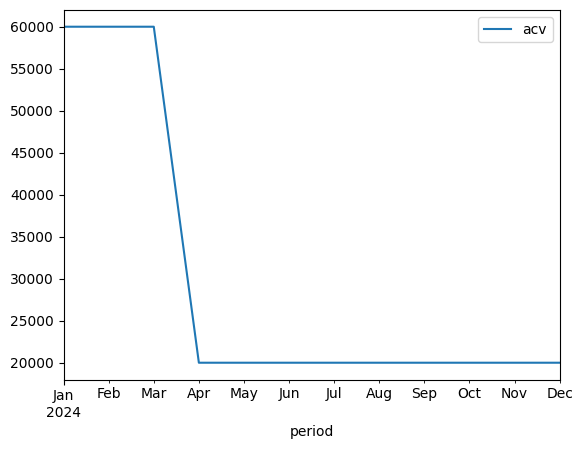

In [26]:
df[['period','acv']].groupby('period').sum().plot()

Take note of the $\text{2,500}$ line amounts for Contract # 1.

When annualizing contracts **shorter** than 1 year, the ACV increases from the TCV. Annualizing contracts **longer** than 1 year, the ACV decreases from TCV. The implications of shorter contracts mean the company will chase after a larger ACV in a shorter amount of time. The example above shows that. Contract # 1 has 4 lines at 2.5k each. When annualizing, the 2.5k increases into 10k, but quickly falls to 0 when the contract is over.

In my experience, shorter contracts are often used as a back door *trial/demo*. It's a way to give a customer the product for a short period of time. This means the renewal implications are not always the same as a full year contract or more, so you're likely to see the big swing in shorter contracts on the down side.

<div class="alert alert-block alert-warning">
At scale, seeing the quick rise and fall of shorter contracts can often push a business decision to not annualize contracts shorter than a 1 year time frame.
</div>

### Ramp Contracts

A [ramp contract](https://dealhub.io/glossary/ramp-deal/) will have a change in price during the term of the contract. A common reason for ramp contracts is to lock the customer in for multiple years. The first year starts at price, then the subsequent years increase in price over time.

In [11]:
ramp_contract = Contract(
    1,
    ContractHeader(36_000, date(2024, 1, 1), date(2026, 12, 31)),
    [
        ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 1, True),
        ContractLine(4_000, date(2024, 1, 1), date(2024, 12, 31), 2, True),
        ContractLine(6_000, date(2025, 1, 1), date(2025, 12, 31), 1, True),
        ContractLine(6_000, date(2025, 1, 1), date(2025, 12, 31), 2, True),
        ContractLine(8_000, date(2026, 1, 1), date(2026, 12, 31), 1, True),
        ContractLine(8_000, date(2026, 1, 1), date(2026, 12, 31), 2, True),
    ],
)
ramp_contract

                      Example Customer                      
             Contract #1 - $36,000 - 2024-01-01             
                  2024-01-01 - 2026-12-31                   
************************************************************
product	start date	end date	amount	renewable
************************************************************
1	2024-01-01	2024-12-31	$4,000	True
2	2024-01-01	2024-12-31	$4,000	True
1	2025-01-01	2025-12-31	$6,000	True
2	2025-01-01	2025-12-31	$6,000	True
1	2026-01-01	2026-12-31	$8,000	True
2	2026-01-01	2026-12-31	$8,000	True
************************************************************

Contract # 1 has a TCV of $\text{36k}$, over the course of 3 years. It has two different items in the contract and ramps up 2k each year for each item. Often times, ACV calculations will only annualize by header dates of contracts. Annualizing at the header does not give the full story.

In [12]:
by_lines = build_acv_table([ramp_contract])
by_header = build_acv_table([ramp_contract], False)

print("ARR of Ramp Contract by Header Dates")
display(by_header)
print("ARR of Ramp Contract by Line Dates")
display(by_lines)

NameError: name 'build_acv_table' is not defined

$\begin{matrix}
 \text{Header} & \to \text{TCV 36k} & \to & \begin{matrix}12k & \to & \text{Year 1}\\ 12k & \to & \text{Year 2}\\ 12k & \to & \text{Year 3}\end{matrix}
 \\\\
\text{Line} & \to \text{TCV 36k} & \to & \begin{matrix}8k & \to & \text{Year 1}\\ 12k & \to & \text{Year 2}\\ 16k & \to & \text{Year 3}\end{matrix}
\end{matrix}$

<div class="alert alert-block alert-info">
Annualizing by the line start and end dates is preferred over annualizing by header start and end dates.
</div>